<a href="https://colab.research.google.com/github/mrefugionv/S6---ICE-VIDEOJUEGOS/blob/main/P6_INTEGRADO_PY_PREPRO_ANAEXP_ANAEST_IceVIDEOJUEGOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Integrado : ICE Videojuegos


La tienda online Ice, que vende videojuegos por todo el mundo, necesita identificar patrones que determinen si un juego tiene éxito o no. Esto le permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Se trabajara con los datos de fuente abierta del año 2016, para pronosticar las ventas del 2017.

Las dos hipótesis que se van a poner a prueba son:

— Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

— Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.


## Acceso al archivo de datos y estudio de la información general.

In [ ]:
#Importación de librería necesarias
import pandas as pd                             #Dataframes y series
from matplotlib import pyplot as plt           # Gráficos
import seaborn as sns                          #Diagramas caja-bigotes
from scipy import stats as st                # Calculos estadísticos

In [ ]:
data = pd.read_csv('datasets/games.csv')   # Importamos datos del archivo csv
data.info()                                 # Impresión de información general del dataframe
print()
print(data.sample(5))                       # Impresión de 5 filas aleatorias
print()
print(data.duplicated().sum())             # Revisar si hay duplicados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

                                   Name Platform  Year_of_Release  \
938                        Just Cause 3      PS4           2015.0   
3846                     SingStar Dance      PS3           2010.0   
8635                        Bulle

Tenemos 10 columnas en el dataframe:
* Name: Nombre del video juego, tipo de dato objeto, con 2 valores auscentes.
* Platform: Plataforma, tipo de dato objeto, sin valores auscentes.
* Year_of_Release: Año de lanzamiento, tipo de dato flotante (a convertir a entero ya que loas años no tienen decimales), con 269 valores ausentes.
* Genre: Género del videojuego, tipo de dato objeto, con 2 valores auscentes.
* NA_sales: Ventas en Norteamérica en millones de dólares estadounidenses, tipo de dato flotante, sin valores auscentes.
* EU_sales: Ventas en Europa en millones de dólares estadounidenses, tipo de dato flotante, sin valores auscentes.
* JP_sales: Ventas en Japón en millones de dólares estadounidenses, tipo de dato flotante, sin valores auscentes.
* Other_sales: Ventas en otros países en millones de dólares estadounidenses, tipo de dato flotante, sin valores auscentes.
* Critic_Score: Puntaje de criticos con un valor máximo de 100,  tipo flotante ( a convertir a entero la calificación esta dada en numeros enteros de 0-100), con 8578 valores auscentes.
* User_Score: Puntaje de usuario con un valor máximo de 10, tipo objeto ( a convertir a tipo flotante, ya que se dan puntajes del 0-10 con un decimal), con 60701 valores auscentes.
* Rating (ESRB):  Almacena la clasificación de edad ESRB de cada juego de acuerdo al Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento), tipo objeto (con estos posibles valores : ['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP'] ), con 6766 valores auscentes.

También sabemos que no hay filas completamente duplicadas.

## Preparación de datos

### Corrección nombre de columnas

La manera estándar de nombrar las columnas es con el formato snake_case; todas las letras estan en minúsculas y las palabras separadas por guión bajo.



In [ ]:
new_col_names =[]

for old_name in data.columns:
    name_stripped = old_name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ','_')
    new_col_names.append(name_no_spaces)

data.columns = new_col_names

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


### Valores auscentes

* name: con 2 valores auscentes, probablemente por error en la captura de datos. Se colocara un string ' ' vacío, tiene que ser del mismo tipo de dato que los demás valores de la columna y no queremos que cualquier otro string indicativo se confunda con el nombre de algún videojuego.
* year_of_release: con 269 valores ausentes, probablemente por es información desconocida. Se rellenaran con los años de lanzamiento que se tengan del mismo videojuego en otras plataformas.
* genre: con 2 valores auscentes,  probablemente por error en la captura de datos. Se colocara un string ' ' vacío, tiene que ser del mismo tipo de dato que los demás valores de la columna y se da a entender que no se posee ninguna información al respecto.
* critic_score: con 8578 valores auscentes, probablemente no todos los videojuegos han sido evaluados por críticos.Se colocara la mediana de los valores no auscentes que se posean en esa columna, para que ser del mismo tipo de dato que los demás valores de la columna y no desvie los resultados.
* user_score:con 60701 valores auscentes, no todos los videojuegos han sido calificados por usuarios. ** En esta columna también se tiene otro valor 'tbd' (to be determined), de acuerdo a los datos revisados son videouegos que se lanzaron el mismo año en que se extrajo la base de datos (2016); por lo tanto se entiende que son videojuegos que estaban a prueba / siendo evaludos en esos momentos y todavía no se obtenia información suficiente para asignar un puntaje de los usuarios ** En esta columna, tanto 'nan' como 'tbd' se tratarán de la misma manera (como valoreas asucentes ambos), ya que de cualquier manera no se posee infromación y debemos asignar un valor del mismo tipo de dato que los valores de la columna (flotante).  El valore que se asiganara a los valores auscentes de esta columna es la mediana de los valores no auscentes que se posean en esa columna, para que ser del mismo tipo de dato que los demás valores de la columna y no desvie los resultados.
* rating (ESRB):   con 6766 valores auscentes, no hn sido evaluados por la ESBR. Se colocara un string ' ' vacío, tiene que ser del mismo tipo de dato que los demás valores de la columna (tipo objeto).

In [ ]:
cols_to_replace_str = ['name','genre','rating']
#Rellena valores vacios (nan) por string vacío en columnas específicadas
for col in cols_to_replace_str :
    data[col].fillna(' ', inplace = True)


# En columna 'user_score' tambien el valor 'tbd' los trataremos como si estuvieran auscentes (mediana de user_score es 7.5)
data['user_score'] = data['user_score'].replace('tbd','7.5')

#Rellena valores vacíos (nan) por la mediana de esa columna específicada
#Creamos serie con los valores no ausentes de la columna, de esta se calcula la mediana
cols_to_replace_number = ['critic_score','user_score']

for col in cols_to_replace_number:
    col_no_nan = data[col].dropna().astype('float')
    median = col_no_nan.median()
    print (f'Mediana de {col} es {median}')
    data[col].fillna(median,inplace=True)


#print(data.info())
#print(data['user_score'].isnull().sum())

In [ ]:
#Rellenar valores ausentes de year con las fechas en otras plataformas
#En caso de que no haya registro del mismo juego en otras plataformas con año, se colocara 0

print(data['year_of_release'].isnull().sum())
data['year_null'] = data['year_of_release'].isna()
print(data['year_of_release'].isnull().sum())

for i in data.index:
    if data.loc[i,'year_null'] == True :
        game = data.loc[i,'name']
        platform = data.loc[i,'platform']
        games = data[data['name'] == game]
        games_diff = games[games['platform'] != platform]
        game_diff_with_year = games_diff[games_diff['year_null'] == False]
        if len(game_diff_with_year)> 0:
            index = game_diff_with_year.index
            year = game_diff_with_year.loc[index[0],'year_of_release']
        else:
            year= 0
        data.loc[i,'year_of_release'] = year
    else:
        data.loc[i,'year_of_release']=data.loc[i,'year_of_release']


# Verificamos cuantas fechas quedaron sin fecha
sum = 0
for i in data.index:
    if data.loc[i,'year_of_release'] == 0:
        sum += 1
    else:
        sum = sum
print(f'fechas en 0:',sum)

print()
print(data.info())

print(data['user_score'].isnull().sum())

269
269
fechas en 0: 146

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  float64
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  float64
 9   user_score       16715 non-null  object 
 10  rating           16715 non-null  object 
 11  year_null        16715 non-null  bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 1.4+ MB
None
0


### Conversión de tipos de datos.

La columna "year_of_release" se converte de tipo de dato flotante a convertir a entero ya que los números que respresentan los años no tienen decimales.

In [ ]:
data['year_of_release'] = data['year_of_release'].astype('int')

La columna "critic_score" se converte de tipo flotante a entero la calificacion esta dada en numeros enteros con valores en un rango del 0 al 100.

In [ ]:
data['critic_score'] = data['critic_score'].astype('int')

La columna "user_score" tiene tipo de dato objeto se converte a tipo flotante, ya que se dan puntajes del 0-10 con un decimal.

In [ ]:
data['user_score'] = data['user_score'].astype('float')
print(data['user_score'].isnull().sum())

0


### Ventas totales
Se crea una nueva columna 'total_sales' donde se guarda la suma total de las ventas de las cuatro regiones para cada uno de los videojuegos.

In [ ]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] +data['jp_sales']+ data['other_sales']
print(data.sample(5))

                                                    name platform  \
15685  SD Gundam Sangokuden Brave Battle Warriors: Sh...       DS   
1130                                            NBA 2K15     X360   
3308                                     Madden NFL 2003      GBA   
2625                                Dead Island: Riptide     X360   
15495  Arcana Famiglia: Vascello Phantasma no Majutsushi      PSP   

       year_of_release   genre  na_sales  eu_sales  jp_sales  other_sales  \
15685             2010  Action      0.00      0.00      0.02         0.00   
1130              2014  Sports      1.35      0.11      0.00         0.17   
3308              2002  Sports      0.44      0.16      0.00         0.01   
2625              2013  Action      0.44      0.26      0.01         0.07   
15495             2012  Action      0.00      0.00      0.02         0.00   

       critic_score  user_score rating  year_null  total_sales  
15685            71         7.5             False        

## Análisis de datos


### Juegos lanzados en diferentes años

Observamos cuántos juegos fueron lanzados en diferentes años.

Los datos de cada periodo parecen sí ser significativos. Los primeros años 1980-1993 tenemos menos de 100 datos para cada año, debemos tomar en cuenta que son los años en los que se comenzaban a comercializar y exteneder el uso de los videojuesgo. Después empiezan a aumentar rápidamente, hasta el año 2011, epóca de popularidad de los videojuegos. Del 2012 al 2016 empieza a decrecer la cantidad de juegos publicados en esos años, la industria de los videojuegos esta perdiendo popularidad.

In [ ]:
data.groupby(by='year_of_release')['name'].count() #Contamos cantidad de videojuegos por año

year_of_release
0        146
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      42
1992      43
1993      62
1994     122
1995     219
1996     263
1997     289
1998     380
1999     339
2000     351
2001     486
2002     845
2003     783
2004     764
2005     947
2006    1019
2007    1202
2008    1441
2009    1430
2010    1269
2011    1153
2012     662
2013     548
2014     581
2015     606
2016     502
Name: name, dtype: int64

### Ventas por plataforma.
Observamos cómo varían las ventas de una plataforma a otra.  
Las plataformas con más ventas son ( en orden descendente): 'PS2', 'X360', 'PS3', 'Wii', 'DS'.

In [ ]:
total_sales_platform = data.groupby(by='platform')['total_sales'].sum() #se obtiene suma total de ventas por plataforma
print (total_sales_platform)

platform
2600      96.98
3DO        0.10
3DS      259.00
DC        15.95
DS       806.12
GB       255.46
GBA      317.85
GC       198.93
GEN       30.77
GG         0.04
N64      218.68
NES      251.05
NG         1.44
PC       259.52
PCFX       0.03
PS       730.86
PS2     1255.77
PS3      939.65
PS4      314.14
PSP      294.05
PSV       54.07
SAT       33.59
SCD        1.86
SNES     200.04
TG16       0.16
WS         1.42
Wii      907.51
WiiU      82.19
X360     971.42
XB       257.74
XOne     159.32
Name: total_sales, dtype: float64


Para buscar las plataformas que solían ser populares pero que ahora no tienen ventas se construye una distribución basada en los datos de cada año.

Resultados:

* Plataformas que, al 2016, estan fuera del mercado:

   Plataformas que solían ser populares pero ya ahora no tienen ventas:
    * 2600 (1980 - 1989 : 10 años)
    * DC (1998 - 2008 : 11 años)
    * DS (2004 - 2013 : 10 años)
    * GB (1998 - 2001 : 14 años)
    * GBA (2000 - 2007 : 8 años)
    * GC (2001 - 2007 : 7 años)
    * N64 (1996 - 2002 : 8 años)
    * NES (1983 - 1994 : 12 años)
    * PS (1994 -2003 : 10 años)
    * PS2 (2000 - 2011 : 12 años)
    * SAT (1994 - 1999 : 6 años)
    * SNES (1990 - 1999 : 10 años)
    * XB ( 2000 - 2008 : 9 años)

  Plataformas que estuvieron 5 o menos años en el mercado:
  * SDO (1994 - 1995 : 2 años)
  * GEN (1990 - 1994 : 5 años)
  * GG (1992 : 1 año)
  * NG (1993 - 1996 : 4 años)
  * PCFX (1996 : 1 año)
  * SCD ( 1993 - 1994 : 2 años)
  * TG16 (1995 : 1 año )
  * WS (1999 - 2001 : 3 años)

* Plataformas que, al 2016, siguen en el mercado:

   Plataformas con popularidad en aumento:
   * PS4 (2013- 2016 : 4 años)
   * XOne (2013 - 2016 : 4 años)

  Plataformas cuya popularidad decrece:
  * 3DS (2011 - 2016 : 6 años)
  * PC (1985, 1988, 1992, 1994 - 2016 : 23 años)
  * PS3 (2006- 2016 : 11 años)
  * PSP (2004 - 2015 : 12 años)
  * PSV (2011 - 2016 : 6 años)
  * Wii ( 2006 - 2016 : 11 años)
  * WiiU (2012 - 2016 : 5 años)
  * X360 (2005 - 2016 : 12 años)

¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?
Con los datos arriba mostrados se puede notar que las plataformas antiguas duraban un promedio de 10 años en el mercado. Las más nuevas, incluyendo aquellas que van en aumento en popularidad, llevan un promedio de 5 años en el mercado. Y existen un tercer grupo que son aquellos que siguen en el mercado depués de más de 10 años de lanzamiento.  

platform          2600   3DO    3DS    DC      DS     GB    GBA     GC    GEN  \
year_of_release                                                                 
1980             11.38   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1981             35.68   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1982             28.88   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1983              5.84   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1984              0.27   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1985              0.45   NaN    NaN   NaN    0.02    NaN    NaN    NaN    NaN   
1986              0.67   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1987              1.94   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1988              0.74   NaN    NaN   NaN     NaN   1.43    NaN    NaN    NaN   
1989              0.63   NaN    NaN   NaN     NaN  64.97    NaN    NaN    NaN   
1990               NaN   NaN

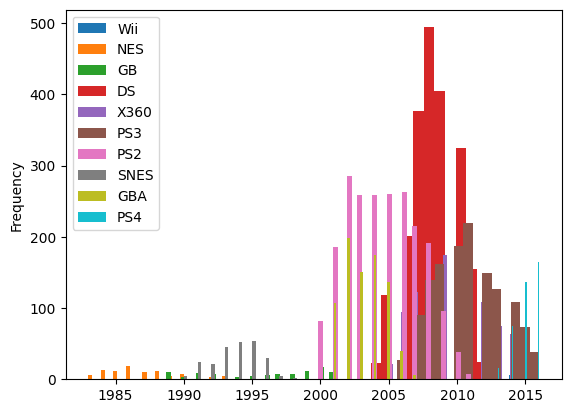

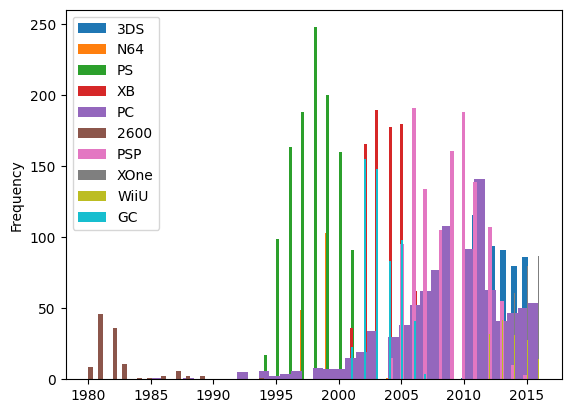

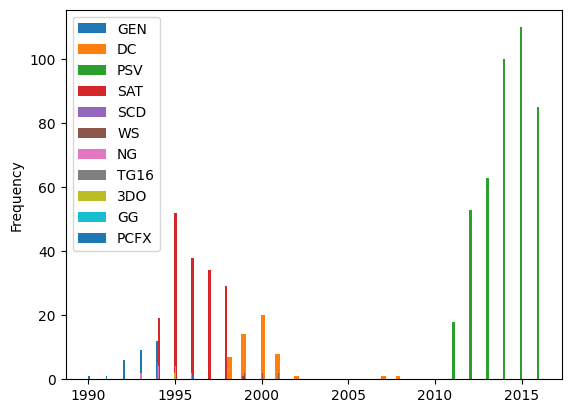

In [ ]:
# Se obtiene dataframe sin las filas con años de lanzamiento 0 que son de los que no se tiene la información
data_no_0_year = data[data['year_of_release'] != 0]

#Se construye tabla dinámica con ventas totales de cada videojuego para cada año
pivot_data = data_no_0_year.pivot_table(index='year_of_release',
                             columns ='platform',
                             values = 'total_sales',
                             aggfunc ='sum')
pd.options.display.max_columns= None  #Para forzar la impresión de todas las columnas
print(pivot_data)


##### Imprimimos histograma de cantidad de videojuegos lanzados por cada plataforma a través de los años###
# También nos ayuda a encontrar como se fueron comportando los lanzamientos en difrentes plataformas a traves de los años #
#Para ahacer la distribución divido las plataformas para que se alcance a distinguir en los gráficos.
platforms1 = ['Wii','NES','GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA', 'PS4']
platforms2 = ['3DS', 'N64','PS' ,'XB','PC', '2600', 'PSP', 'XOne', 'WiiU', 'GC']
platforms3 = ['GEN', 'DC', 'PSV', 'SAT','SCD', 'WS', 'NG','TG16', '3DO', 'GG', 'PCFX']


for platform in platforms1:
    data_no_0_year[data_no_0_year['platform']==platform]['year_of_release'].plot(kind='hist', bins = 36)
plt.legend(['Wii','NES','GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA', 'PS4'])
plt.show()

for platform in platforms2:
    data_no_0_year[data_no_0_year['platform']==platform]['year_of_release'].plot(kind='hist', bins = 36)
plt.legend(['3DS', 'N64','PS' ,'XB','PC', '2600', 'PSP', 'XOne', 'WiiU', 'GC'])
plt.show()

for platform in platforms3:
    data_no_0_year[data_no_0_year['platform']==platform]['year_of_release'].plot(kind='hist', bins = 36)
plt.legend(['GEN', 'DC', 'PSV', 'SAT','SCD', 'WS', 'NG','TG16', '3DO', 'GG', 'PCFX'])
plt.show()

### Análisis descriptivo

Se determina que el período que se tomará en cuenta para construir un modelo para 2017, sera de 15 años (2004 - 2016); es el periodo en el que han estado funcionando las plataformas que aún son rentables, execeptuando PC.

La plataformas que permanecen rentables a 2016 son: PS4, XOne, 3DS, PC, PS3, PSP, PSV, Wii, WiiU, X360.


#### Diagarama de caja

Creamos un diagrama de caja para las ventas globales de cada juego de los seleccionados a estudiar.

¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.

* PS4    (min=  2     , Q1=  58        , mediana =  85       , Q3=  105     , max =  119  , media =  79 )
* XOne   (min=   19   , Q1=  24        , mediana =  40        , Q3= 56      , max =   60 , media = 40   )
* 3DS    (min=   12  , Q1=   32       , mediana =   48       , Q3=   55    , max =    63  , media = 43 )
* PC  +   (min=   0    , Q1=  4        , mediana =   9       , Q3=    12   , max =    35   , media = 10)
* PS3    (min=   4    , Q1=  34        , mediana =  107        , Q3=   125    , max =  157  , media = 85   )
* PSP    (min=   0    , Q1=  6        , mediana =   26       , Q3=   39    , max =   55  , media = 24  )
* PSV    (min=   4    , Q1=  5        , mediana =   8       , Q3=   12    , max =    16  , media = 9 )
* Wii     (min=  0     , Q1= 6         , mediana =  60        , Q3=  145     , max =  207  , media = 81   )
* WiiU -    (min=  5     , Q1= 16         , mediana = 18         , Q3=  22     , max =  22  , media = 16   )
* X360    (min=  2     , Q1=  29        , mediana =  92        , Q3=   124    , max =   170  , media = 80  )

Sí hay diferencias significativas en las ventas de los diferentes videojuegos, para poder diferenciar cuales son los video juegos más rentables suele se útil comparar la media(promedio) con la mediana de las ventas de cada uno de los juegos; para hacer una interpretación correcta hay que tomar en cuenta dos factores:
* Los valores atípicos:  Si son muy extremos este puede alterar el valor de la media como el caso de PC que tiene un valor átipo mayor al máximo provocando que la media sea mayor a la mediana y en el caso de WiiU un valor atípico menor al mínimo produciendo una media menor a la mediana.
* La distribución : Podemos observar que en ocasiones en las que la media es menor que la mediana sin que haya valores atípicos ( como el caso de PS3), esto se debe a que hay veces que los variables empiezan a tomar valores mucho más pequeños que las mediana y llegan a tomar valores no tan grandes como para compensar. Y en ocasiones sucede lo opuesto (ejemplo; Wii), las variables llegan a tomar valores mucho más grandes que las mediana y pero empizan a tomar valores no tan pequeños como para compensar.  La diferencia mediana- Q1 y la diferencia Q2 - mediana, podemos ver hacia donde estan cargados los valores de la variable, si estas dos diferencias son iguales quiere descir que hay una distribución normal y hay una distribución simétrica; si la diferencia mediana - Q1 es mayor que Q2-mediana entonces hay un sesgo a la izquierda; por el contrario si Q2-mediana es mayor que mediana- Q1  existe un sesgo a la derecha.

Para este caso PS3, Wii, X360 y PS4 son los videojuegos con mayores ganancias.

NOTA: Los valores aquí expuestos estan redondeados hacia abajo si decimales menor a 0.5 y hacia arriba si 0.5 o mayor. Los valores exactos se pueden consultar al ejecutar el código de abajo.

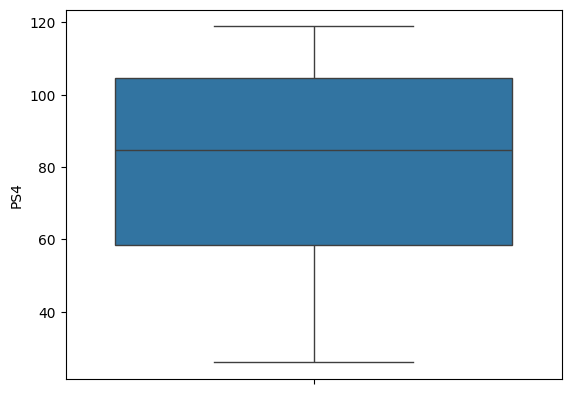

count      4.000000
mean      78.535000
std       40.567917
min       25.990000
25%       58.435000
50%       84.625000
75%      104.725000
max      118.900000
Name: PS4, dtype: float64


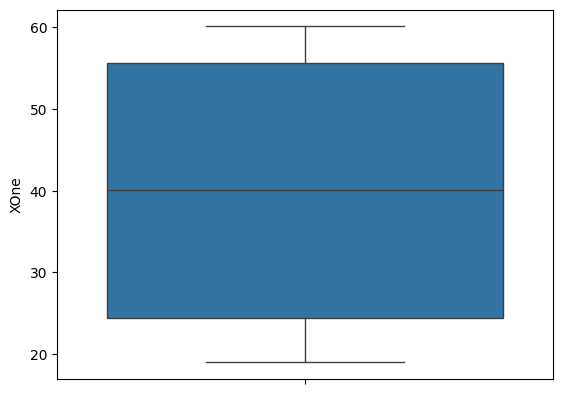

count     4.000000
mean     39.830000
std      20.313977
min      18.960000
25%      24.352500
50%      40.110000
75%      55.587500
max      60.140000
Name: XOne, dtype: float64


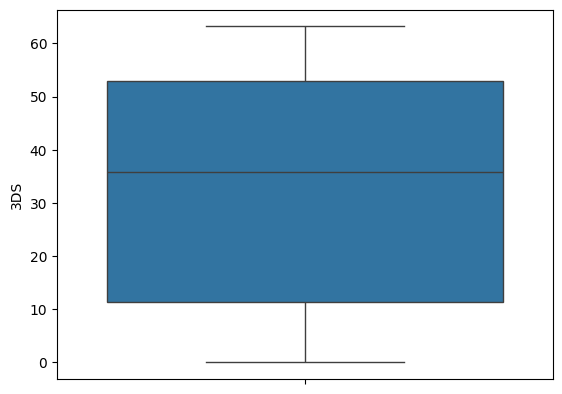

count     8.000000
mean     32.316250
std      25.170159
min       0.020000
25%      11.430000
50%      35.770000
75%      52.962500
max      63.200000
Name: 3DS, dtype: float64


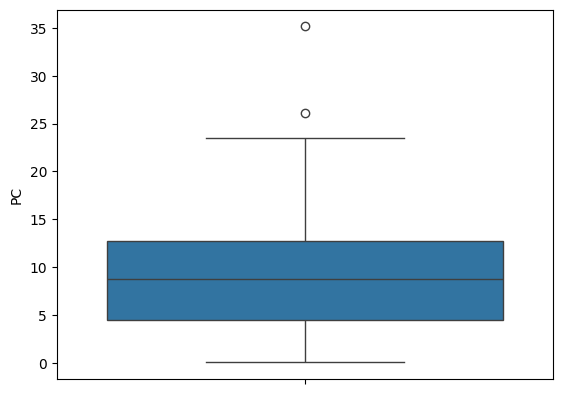

count    26.000000
mean      9.956154
std       8.184351
min       0.030000
25%       4.450000
50%       8.730000
75%      12.767500
max      35.160000
Name: PC, dtype: float64


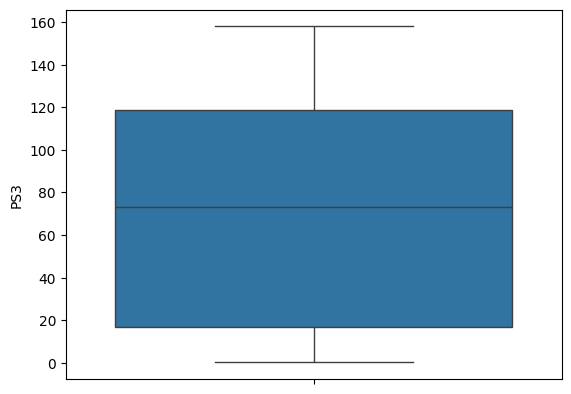

count     13.000000
mean      71.937692
std       59.369560
min        0.190000
25%       16.820000
50%       73.190000
75%      118.790000
max      157.980000
Name: PS3, dtype: float64


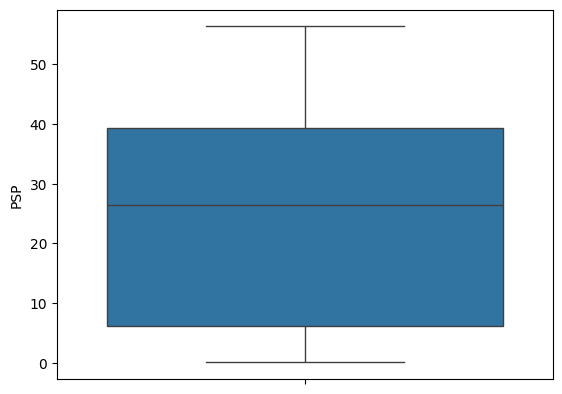

count    12.000000
mean     24.464167
std      20.434488
min       0.120000
25%       6.140000
50%      26.430000
75%      39.295000
max      56.280000
Name: PSP, dtype: float64


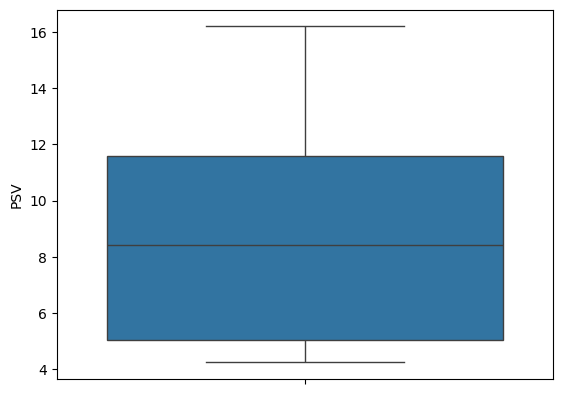

count     6.000000
mean      8.968333
std       4.729695
min       4.250000
25%       5.035000
50%       8.420000
75%      11.572500
max      16.190000
Name: PSV, dtype: float64


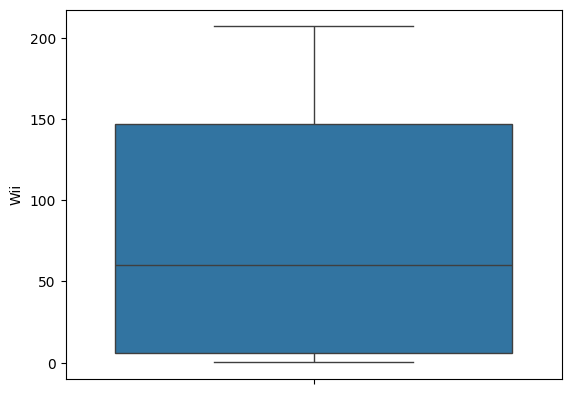

count     11.000000
mean      82.119091
std       80.101105
min        0.180000
25%        6.170000
50%       59.790000
75%      146.800000
max      206.970000
Name: Wii, dtype: float64


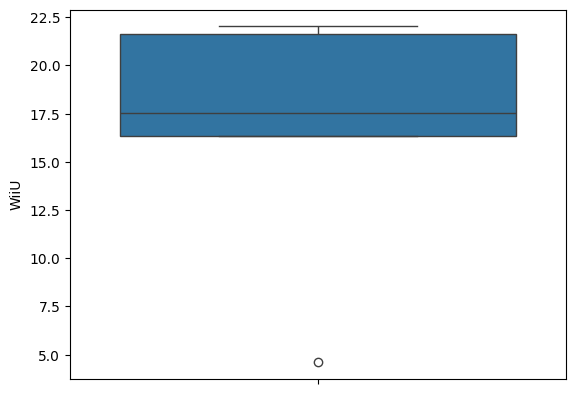

count     5.000000
mean     16.438000
std       7.068244
min       4.600000
25%      16.350000
50%      17.560000
75%      21.650000
max      22.030000
Name: WiiU, dtype: float64


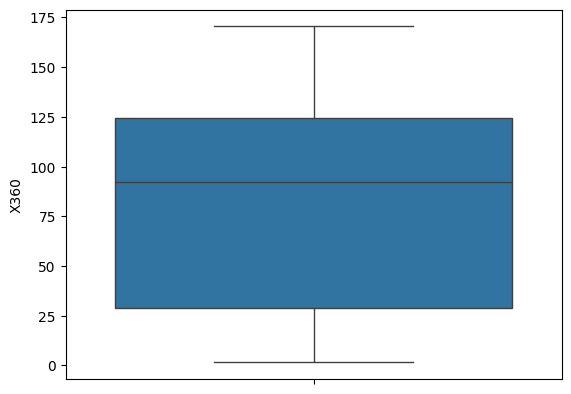

count     12.000000
mean      80.550833
std       57.716995
min        1.520000
25%       29.045000
50%       91.995000
75%      124.632500
max      170.550000
Name: X360, dtype: float64


In [ ]:
platforms_selected = ['PS4', 'XOne', '3DS', 'PC', 'PS3', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360']

for platform in platforms_selected:
    sns.boxplot(pivot_data[platform])
    plt.show()
    print(pivot_data[platform].describe())


#### Gráfico de dispersión

Para observar cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular, se elige la plataforma PS3 por ser la que en promedio ha generado mayores ventas, lleva 11 años en el mercado y sigue generando ganancias.  
Conclusiones:

Al calcular la correlacion entre las reseñas y las ventas podemos ver que sí hay una correlación positiva, sin embargo, para ambos casos ( reseñas de usuario y de criticos) esas relaciones son muy pequeña.

Al crear los gráficos de dispersión se facilita visualizar estas relaciones. Para el caso de la correlación entre ventas totales y reseña de usuario podemos ver que aunque hay varios videojuegos con reseñas altas no todos tuvieron grandes ventas,así como tambien hay videojuegos con reseñas bajas que obtivieron más ventas que otros con mayor calificación.
Para el caso de la correlacion entre ventas totales y reseñas de críticos observamos que hay una correlación mayor, si bien hay muchos videojuegos que no tuvieron grandes ventas, los videojuegos con mayores ventas sí se encuentran entre los mejor calificados.

Correlación ventas con reseña usuario: 0.041004026504435964
Correlación ventas con reseña critico: 0.39741296091581324


<function matplotlib.pyplot.show(close=None, block=None)>

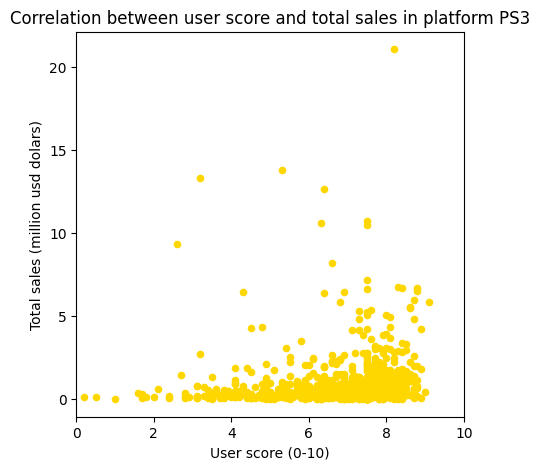

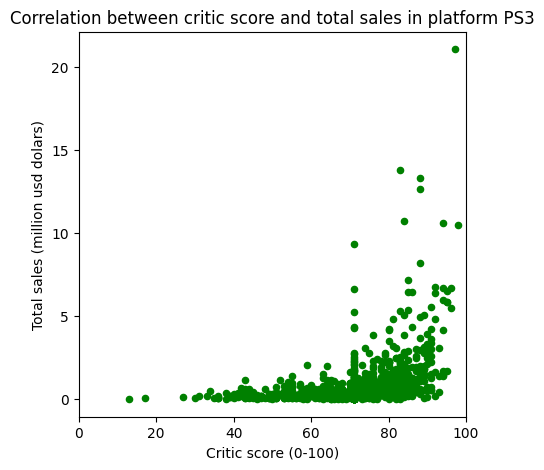

In [ ]:
data_PS3 = data[data['platform'] == 'PS3']

print (f'Correlación ventas con reseña usuario:', data_PS3['user_score'].corr(data_PS3['total_sales']))
print ( f'Correlación ventas con reseña critico:', data_PS3['critic_score'].corr(data_PS3['total_sales']))

data_PS3.plot(x='user_score',
             y = 'total_sales',
              kind ='scatter',
             title = 'Correlation between user score and total sales in platform PS3',
             color = 'gold',
             figsize = [5,5],
             xlim =  [0,10],
             xlabel = 'User score (0-10)',
             ylabel = 'Total sales (million usd dolars)')
plt.show

data_PS3.plot(x='critic_score',
             y = 'total_sales',
              kind ='scatter',
             title = 'Correlation between critic score and total sales in platform PS3',
             color = 'green',
             figsize = [5,5],
             xlim =  [0,100],
             xlabel = 'Critic score (0-100)',
             ylabel = 'Total sales (million usd dolars)')
plt.show


#### Ventas en distintas plataformas
Se comparan las ventas de los mismos juegos en diferentes plataformas.

En la gráfica creada vemos cada videojuego que esta presente en varias plataformas por un color distinto, por lo que hay varias barritas de cada color representando cuantas ventas tuvo ese videojuego en cada plataforma que esta presente. Vemos como dependiendo el videojuego y las opciones de plataformas en las que se los usurarios prefieren : 'PS', 'PS3', 'DS'. También es importante señalar, la gran cantidad de videojuegos que estan adaptados a 'Wii', en esta plataforma aunque no es la que produce la mayor cantidad de un juego en particular, sí produce ventas en la diversidad de juegos que tiene al mercado.


C:\Users\cucum\AppData\Local\Temp\ipykernel_2368\3427259259.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_diff_platforms[col].fillna(0,inplace=True)


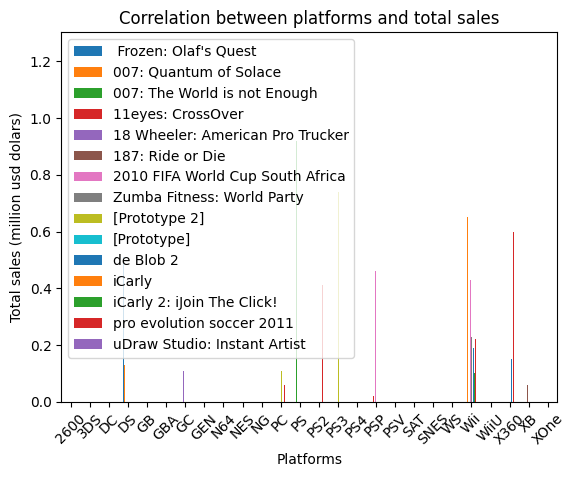

In [ ]:
# Se crea dataframe con los títulos repetidos ( los que se encuentran en más de una plataforma,además de PS3)
games_duplicated = data[data['name'].duplicated() == True]

#Se crea tabla dinamica con plataforma como indice, videojuegos como columna y las ventas totales como valor
sales_diff_platforms = games_duplicated.pivot_table(index='platform',
                                                    columns = 'name',
                                                    values ='total_sales',
                                                    aggfunc = 'sum')

#Los valores auscentes en la tabla dinamica se reemplazan por ceros
for col in sales_diff_platforms.columns:
    sales_diff_platforms[col].fillna(0,inplace=True)
#Se crea la columna con los nombres de plataformas para poder graficar
sales_diff_platforms['platform'] = sales_diff_platforms.index

#Se selecionan algunos video juegos para no sobre cargar la imagen
#print(sales_diff_platforms.columns)

games = [f' Frozen: Olaf\'s Quest',
         '007: Quantum of Solace',
         '007: The World is not Enough',
         '11eyes: CrossOver',
         '18 Wheeler: American Pro Trucker',
         '187: Ride or Die',
         '2010 FIFA World Cup South Africa',
         'Zumba Fitness: World Party',
         '[Prototype 2]',
         '[Prototype]',
         'de Blob 2',
         'iCarly',
         'iCarly 2: iJoin The Click!',
         'pro evolution soccer 2011',
         'uDraw Studio: Instant Artist'
        ]

sales_diff_platforms.plot(x= 'platform',
                          y = games,
                          kind='bar',
                          title ='Correlation between platforms and total sales',
                          ylabel = 'Total sales (million usd dolars)',
                          xlabel = 'Platforms',
                          rot = 45)

plt.legend(games)
plt.show()


#### Distribución por género
Revisamos la distribución general de los juegos por género.

¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?

Encontramos que el genero más rentable es 'Action', seguido por 'Sports'. Los tres menos rentables son 'Strategy', 'Puzzle', y 'Adventure'.
No se puede generalizar, hay características que comparten generos que son muy rentables y que son menos rentables.

genre
                   2.42
Action          1744.17
Adventure        237.59
Fighting         447.53
Misc             802.51
Platform         827.77
Puzzle           242.57
Racing           728.67
Role-Playing     934.56
Shooter         1052.45
Simulation       389.97
Sports          1331.27
Strategy         174.23
Name: total_sales, dtype: float64


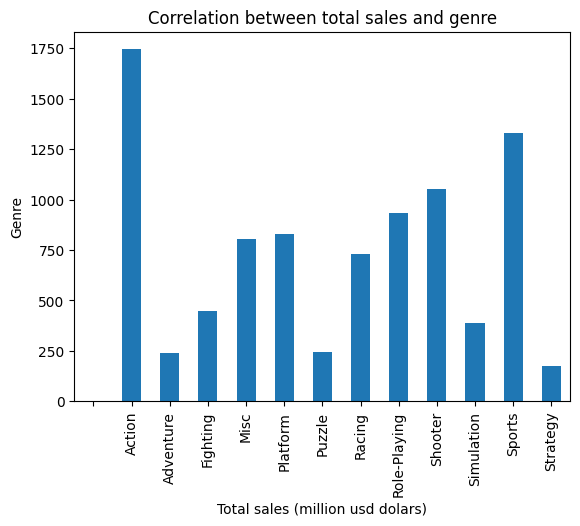

In [ ]:
sales_per_genre = data.groupby(by='genre')['total_sales'].sum()
print(sales_per_genre)

sales_per_genre.plot(x='genre',
                     y = 'total_sales',
                     kind ='bar',
                     title = 'Correlation between total sales and genre',
                     ylabel = 'Genre',
                     xlabel = 'Total sales (million usd dolars)')
plt.show()

## Perfil de usuario por región

¿Diferencias entre regiones?
Se observa que las regiones de NA y EU tienen gustos muy similares, mientras que en JP los resultados varian mucho más:
* Plataformas: En NA y EU entre las 5 más utilizadas figuran en común 4 (X360,PS2,Wii,PS3), mientras que en JP son figuran dos poco usadas en las otras regiones ( SNES y 3DS).
* Género: Los tres comparten Action, Sports, Miscelania; sin embargo en JP estos se ven opacados por un género preferido: Role- Playing. EU y NA además comparten el género Shooter.
* Claificación ESRB : En las tres regiones el preferido es 'E', despues en meros proporciones 'T', 'M', 'E10+' en ese orden (solo en EU se invierte en orden 'T' y 'M'). Cabe hacer notar que en JP se tiene muy poca cantidad de información en cuanto a la clasificación ESRB, es mucho mayor la proporción de valores auscentes.

### Región Norte América
   
* NA:
   * Las cinco plataformas principales: X360, PS2, Wii, DS, PS3
   * Los cinco géneros principales: Action, Sports, Shooter, Platform, Misc
   * ¿Las clasificaciones de ESRB afectan a las ventas de esta región? Los juegos más populares tienen cladificación 'E', le siguen con la misma proporción 'T' y 'M', después la clasificación 'E10+' , y las demás clasificación casi no figuran en la gráfica a comparación.

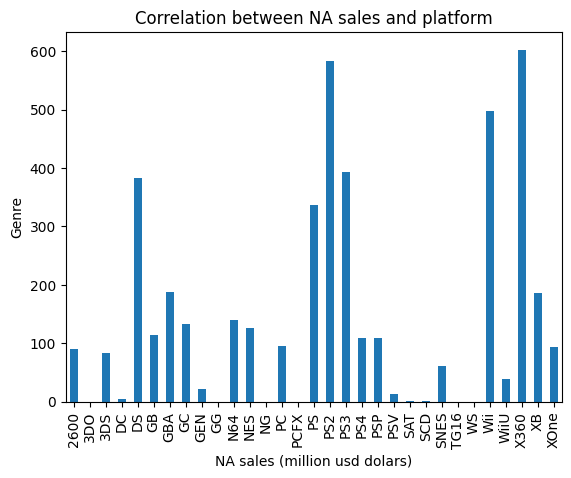

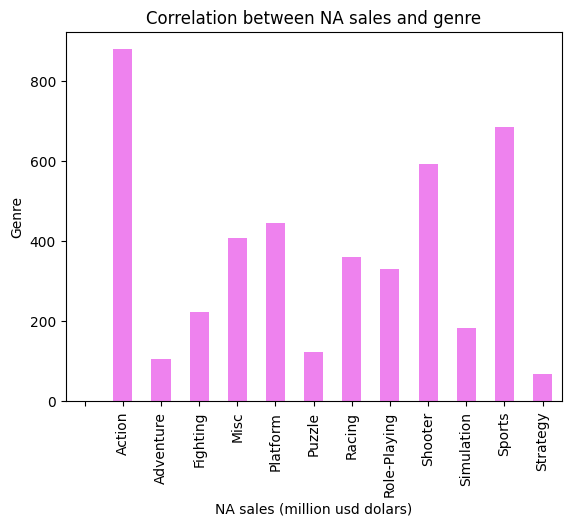

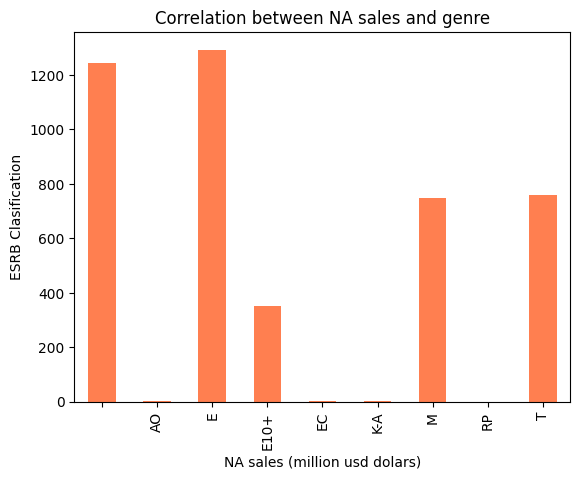

In [ ]:
#Determinar las 5 plataformas principales:

sales_per_platform_na = data.groupby(by='platform')['na_sales'].sum()
sales_per_platform_na.plot(x='platform',
                           y = 'na_sales',
                           kind ='bar',
                           title = 'Correlation between NA sales and platform',
                           ylabel = 'Genre',
                           xlabel = 'NA sales (million usd dolars)')
plt.show()

# Determinar los 5 géneros principales
sales_per_genre_na = data.groupby(by='genre')['na_sales'].sum()
sales_per_genre_na.plot(x='genre',
                        y = 'na_sales',
                        kind ='bar',
                        title = 'Correlation between NA sales and genre',
                        ylabel = 'Genre',
                        xlabel = 'NA sales (million usd dolars)',
                       color='violet')
plt.show()

# Los ESRB afectan las ventas de esta región
sales_per_rating_na = data.groupby(by='rating')['na_sales'].sum()
sales_per_rating_na.plot(x='rating',
                         y = 'na_sales',
                         kind ='bar',
                         title = 'Correlation between NA sales and genre',
                         ylabel = 'ESRB Clasification',
                         xlabel = 'NA sales (million usd dolars)',
                         color='coral')
plt.show()

### Región Unión Europea
   
* EU:
   * Las cinco plataformas principales: PS2, PS3, X360, Wii, PS
   * Los cinco géneros principales: Action, Sports, Shooter, Racing, Misc
   * ¿Las clasificaciones de ESRB afectan a las ventas de esta región? La clasificación más popular es 'E', continuamos con 'M', 'T', 'E10+' en orden descendente; el resto son muy poco utilizados.
   

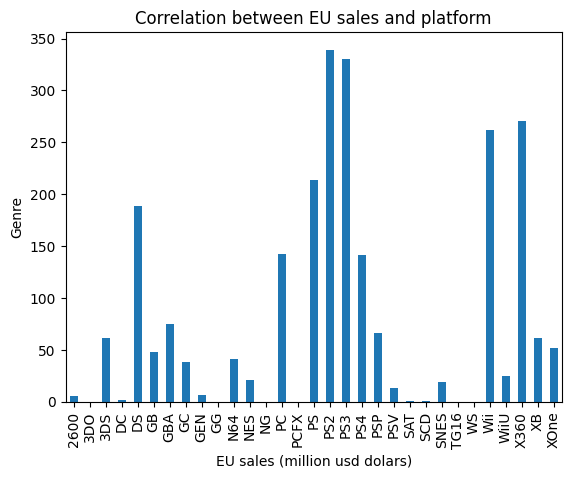

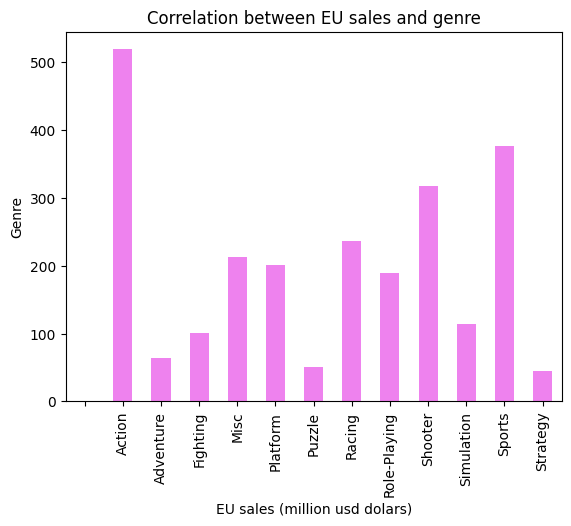

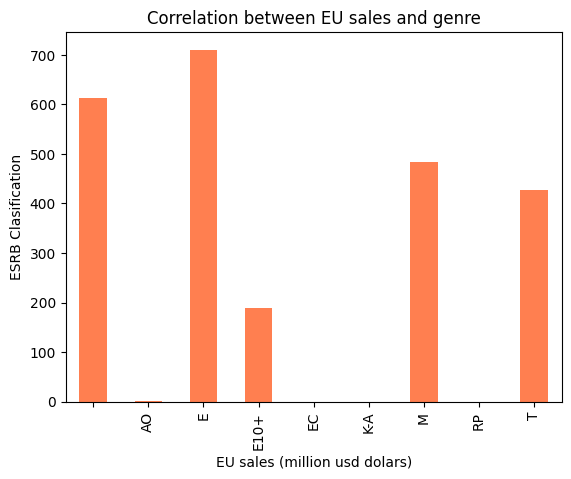

In [ ]:
#Determinar las 5 plataformas principales:

sales_per_platform_eu = data.groupby(by='platform')['eu_sales'].sum()
sales_per_platform_eu.plot(x='platform',
                           y = 'eu_sales',
                           kind ='bar',
                           title = 'Correlation between EU sales and platform',
                           ylabel = 'Genre',
                           xlabel = 'EU sales (million usd dolars)')
plt.show()

# Determinar los 5 géneros principales
sales_per_genre_eu = data.groupby(by='genre')['eu_sales'].sum()
sales_per_genre_eu.plot(x='genre',
                        y = 'eu_sales',
                        kind ='bar',
                        title = 'Correlation between EU sales and genre',
                        ylabel = 'Genre',
                        xlabel = 'EU sales (million usd dolars)',
                       color='violet')
plt.show()

# Los ESRB afectan las ventas de esta región
sales_per_rating_eu = data.groupby(by='rating')['eu_sales'].sum()
sales_per_rating_eu.plot(x='rating',
                         y = 'eu_sales',
                         kind ='bar',
                         title = 'Correlation between EU sales and genre',
                         ylabel = 'ESRB Clasification',
                         xlabel = 'EU sales (million usd dolars)',
                         color='coral')
plt.show()

### Región Japón
   
* JP:
   * Las cinco plataformas principales: DS, PS, PS2, SNES, 3DS
   * Los cinco géneros principales: Role-Playing, Action, Sports, Platform, Misc
   * ¿Las clasificaciones de ESRB afectan a las ventas de esta región? En orden descendente 'E', 'T', 'M','E10+'. Aquí notamos que hay mucho valores auscente, que la información con la que sí contamos.

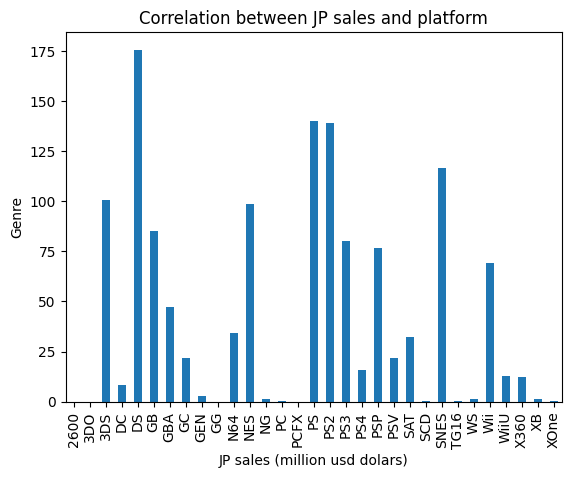

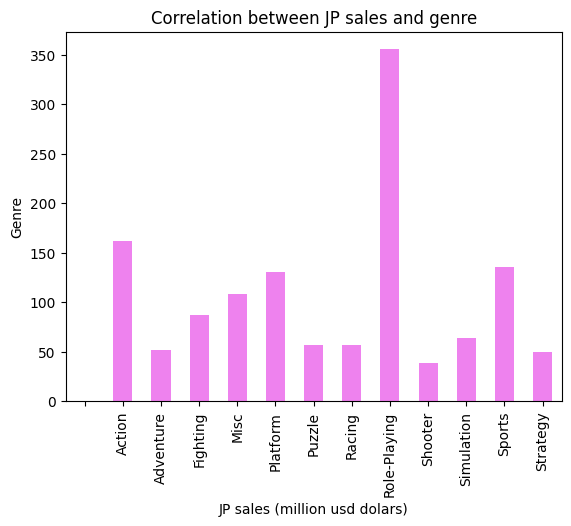

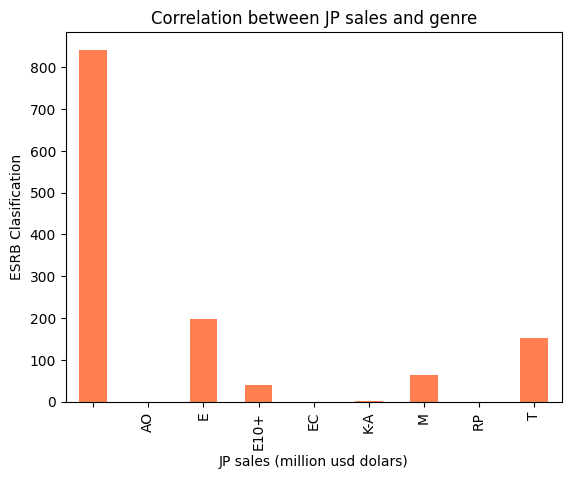

In [ ]:
#Determinar las 5 plataformas principales:

sales_per_platform_jp = data.groupby(by='platform')['jp_sales'].sum()
sales_per_platform_jp.plot(x='platform',
                           y = 'jp_sales',
                           kind ='bar',
                           title = 'Correlation between JP sales and platform',
                           ylabel = 'Genre',
                           xlabel = 'JP sales (million usd dolars)')
plt.show()

# Determinar los 5 géneros principales
sales_per_genre_jp = data.groupby(by='genre')['jp_sales'].sum()
sales_per_genre_jp.plot(x='genre',
                        y = 'jp_sales',
                        kind ='bar',
                        title = 'Correlation between JP sales and genre',
                        ylabel = 'Genre',
                        xlabel = 'JP sales (million usd dolars)',
                       color='violet')
plt.show()

# Los ESRB afectan las ventas de esta región
sales_per_rating_jp = data.groupby(by='rating')['jp_sales'].sum()
sales_per_rating_jp.plot(x='rating',
                         y = 'jp_sales',
                         kind ='bar',
                         title = 'Correlation between JP sales and genre',
                         ylabel = 'ESRB Clasification',
                         xlabel = 'JP sales (million usd dolars)',
                         color='coral')
plt.show()

## Prueba de hipótesis

### Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

* Hipotesis nula:Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.
* Hipotesis alternativa: Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.
* Criterio para probar hipótesis: Sera hipótesis de dos colas, ya que queremos saber si son iguales. No importa si el otro valor medio cae a ala izquierda o derecha ya que será igualmente considerado "diferente". Aún no tenemos argumentos para pensar que las hipótesis nula es cierta, sin embargo se calcula las varianzas y se hace la prueba de Levene para decircir si se asigna el valor 'equal_var = False' o no. Se usará valor alfa 5%.

* Resultado : Se rechaza hiótesis nula, por lo que aceptamos hipótesis alternativa: Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.


0
0


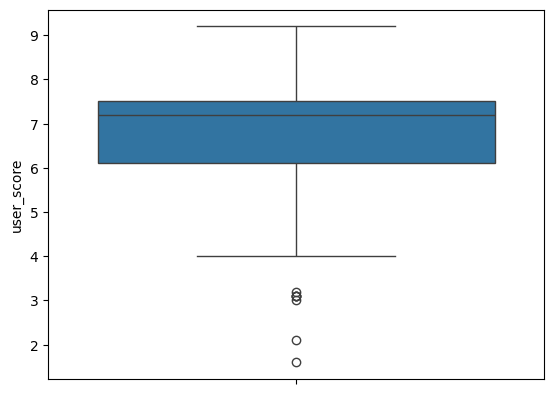

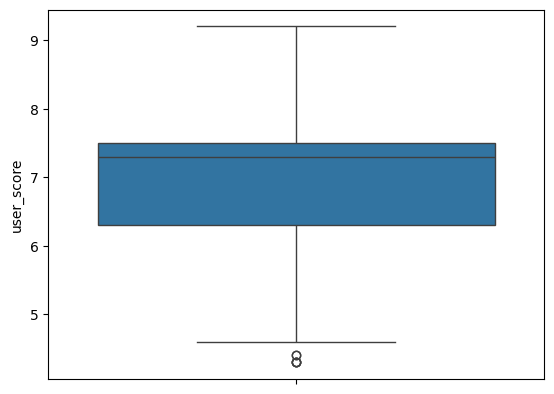

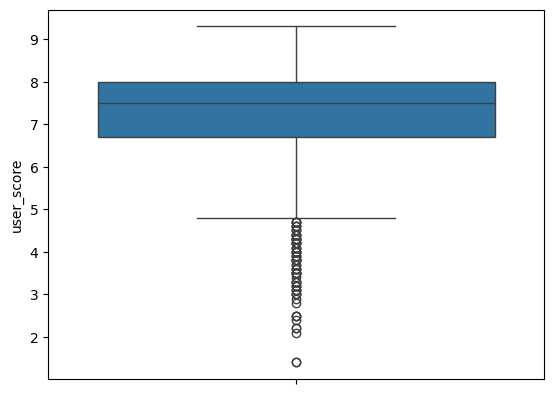

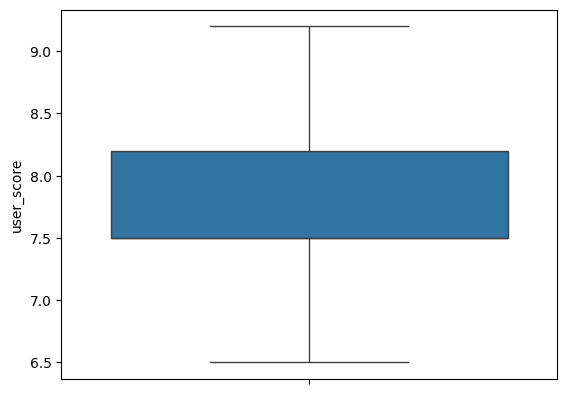

Varianza XOne: 0.9599228950718312

Varianza PC: 0.34986159290795044

Valor P Levene: 1.1213860669412938e-13

Valor p st.ttest: 1.4355394065024916e-26

Rechazamos hipótesis nula


In [ ]:
print(data['user_score'].isnull().sum())

# Se obtienen serie de valores de reseñas de usuario para Xbox One
df_XOne = data[data['platform']=='XOne']
df_user_score_XOne = df_XOne['user_score']
print(df_user_score_XOne.isnull().sum())
     #Observar valores atípicos
sns.boxplot(df_user_score_XOne)
plt.show()
   #Eliminar valores atípicos
for i in df_user_score_XOne.index:
    value = df_user_score_XOne[i]
    if value < 4.3:
        df_user_score_XOne.pop(i)
    else:
        df_user_score_XOne = df_user_score_XOne

sns.boxplot(df_user_score_XOne)
plt.show()

# Se obtienen serie de valores de reseñas de usuario para PC
df_PC = data[data['platform']=='PC']
df_user_score_PC = df_PC['user_score']
   #Observar valores atípicos
sns.boxplot(df_user_score_PC)
plt.show()
    #Eliminar valores atípicos
for i in df_user_score_PC.index:
    value = df_user_score_PC[i]
    if (value < 6.5) or (value > 9.2):
        df_user_score_PC.pop(i)
    else:
        df_user_score_PC = df_user_score_PC

sns.boxplot(df_user_score_PC)
plt.show()

## PRUEBA DE LEVENE ##

# Claculo de varianzas
var_XOne = df_user_score_XOne.var()
print(f'Varianza XOne: {var_XOne}')
print()

var_PC = df_user_score_PC.var()
print(f'Varianza PC: {var_PC}')
print()

#Prueba de Levene
levene_results = st.levene(df_user_score_XOne, df_user_score_PC)
print (f'Valor P Levene: {levene_results.pvalue}')
print()

## COMPROBAMOS HIPÓTESIS ##

# alpha
alpha = 0.05
results = st.ttest_ind(df_user_score_XOne, df_user_score_PC, equal_var = False)
#equal_var = False, no se puede asegurar que las varianzas son diferentes para XOne= 0.95 para PC = 0.349.

#Una condicion para rechazar hipótesis nula de 2 colas:
 #La diferencia entre los valores es estadísticamente significativa

print(f'Valor p st.ttest: {results.pvalue}')
print()
if (results.pvalue < alpha): #es una prueba de dos colas (valor de p no se divide entre dos.)
    print("Rechazamos hipótesis nula")
else:
    print("No hay motivos suficientes para rechazar hipótesis nula")

### Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

* Hipotesis nula: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales.
* Hipotesis alternativa: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.
* Criterio para probar hipótesis: Sera hipótesis de dos colas, ya que queremos saber si son diferentes; no importa si el valor promedio de acción cae a ala izquierda o derecha de la media de deportes ya que será igualmente considerado "diferente". Tenemos argumentos para pensar que las hipótesis nula es falsa (equal_var = False), por las gráficas generadas en la sección anterior vemos que en las tres regiones se vende más 'acción' que 'deportes'. Se usará valor alfa 5%

* Resultados: se rechaza hipótesis nula, por lo que se acepta hipótesis alternativa: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

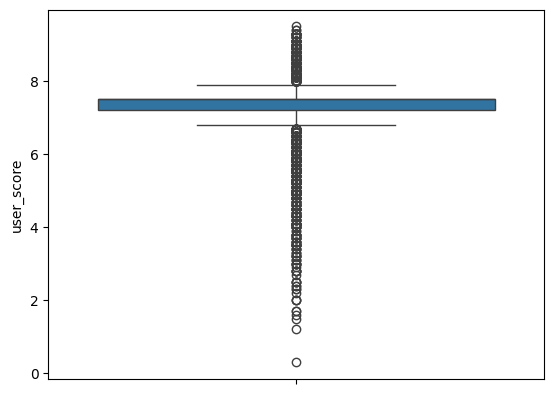

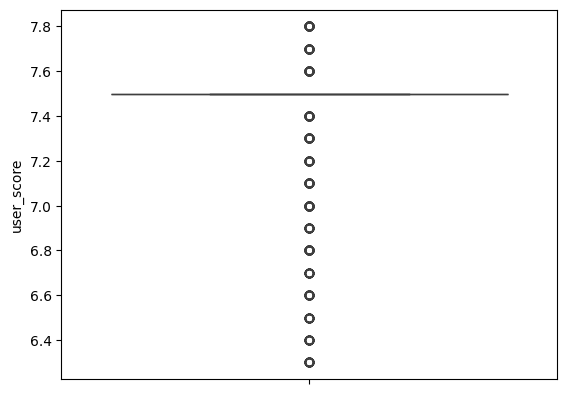

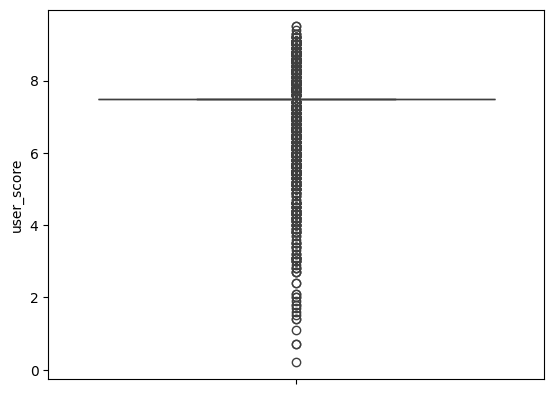

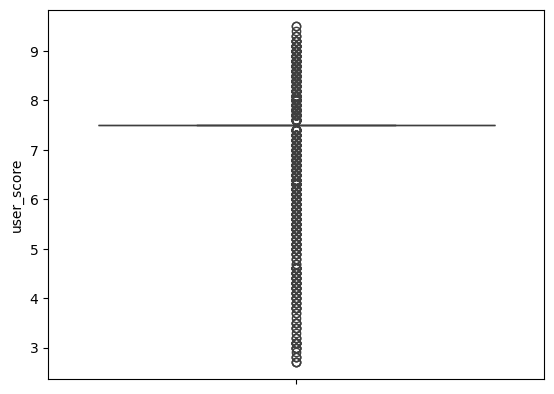

Varianza XOne: 0.0952522800470212

Varianza PC: 1.0504681760301626

Valor P Levene: 7.925826610565482e-83

Valor p (Resultados st.ttest): 4.780642358370365e-05
Rechazamos hipótesis nula


In [ ]:
# Se obtiene serie de valores de reseñas de usuario para género Acción
df_action = data[data['genre']=='Action']
df_user_score_action = df_action['user_score']
     #Observar valores atípicos
sns.boxplot(df_user_score_action)
plt.show()
   #Eliminar valores atípicos
for i in df_user_score_action.index:
    value = df_user_score_action[i]
    if (value < 6.3) or (value > 7.8):
        df_user_score_action.pop(i)
    else:
        df_user_score_action = df_user_score_action

sns.boxplot(df_user_score_action)
plt.show()

# Se obtiene serie de valores de reseñas de usuario para género Deportes
df_sports = data[data['genre']=='Sports']
df_user_score_sports = df_sports['user_score']
     #Observar valores atípicos
sns.boxplot(df_user_score_sports)
plt.show()
   #Eliminar valores atípicos
for i in df_user_score_sports.index:
    value = df_user_score_sports[i]
    if value < 2.5:
        df_user_score_sports.pop(i)
    else:
        df_user_score_sports = df_user_score_sports

sns.boxplot(df_user_score_sports)
plt.show()

## PRUEBA DE LEVENE ##

# Claculo de varianzas
var_action = df_user_score_action.var()
print(f'Varianza XOne: {var_action}')
print()

var_sports = df_user_score_sports.var()
print(f'Varianza PC: {var_sports}')
print()

#Prueba de Levene
levene_results = st.levene(df_user_score_action, df_user_score_sports)
print (f'Valor P Levene: {levene_results.pvalue}')
print()


######

## COMPROBAMOS HIPÓTESIS ##

alpha = 0.05
results = st.ttest_ind(df_user_score_action, df_user_score_sports, equal_var=False)
#equal_var = False, las varianzas son distantes action = 1.05 sports=0.09 y valor p de levene (7.92e-83) es menor a alpha (0.05)


#Una condicion para rechazar hipótesis nula de 2 colas:
 #La diferencia entre los valores es estadísticamente significativa
print(f'Valor p (Resultados st.ttest): {results.pvalue}')
if (results.pvalue < alpha): #es una prueba de dos colas (valor de p no se divide entre dos.)
    print("Rechazamos hipótesis nula")
else:
    print("No hay motivos suficientes para rechazar hipótesis nula")

## Conclusión general

Un analista de datos debe hacer un manejo conciente de los datos de la base de datos dada para poder obtener la información requerida y útil para la toma de decisiones.  Siempre tomando en cuenta la formas estándares de manejor para asegurar un buen resultado y la reproducibilidad y entendimiento del proceso:

* En preprocesamiento de los datos: se lee el archivo y se asegura que no este en los formatos correctoas para su uso (columas descriptivas y en snake_case, tipos de datos adecuados a los valores de cada columna, rtellenar o eliminar filas con valores auscentes).
* El procesamiento de los datos: Incluye el calculo de nuevas columnas a partir de las existentes según sea necesario, el análisis de los datos, formando gráficas y obteniendo valores estadísticos para responder firentes preguntas y entender el comportamiento general de los datos.
* Poner a prueba hipótesis: Planteamiento de hipótesis nula y alternativa, obtención de la probabilidad de que una u otra suceda.